# OpenET SIMS
## Image Mapping Examples
This example shows how you could build an ET image collection by mapping the model image class over a GEE Landsat image collection.

In [1]:
import pprint

import ee

from IPython.display import Image
import openet.sims as model

ee.Initialize()


In [2]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

image_size = 768


### Input parameters

In [3]:
collection_id = 'LANDSAT/LC08/C02/T1_L2'
cellsize = 30

et_reference_source = 'projects/openet/assets/reference_et/california/cimis/daily/v1'
et_reference_band = 'eto'
# et_reference_source = 'IDAHO_EPSCOR/GRIDMET'
# et_reference_band = 'eto'

# Date range you want to aggregate ET over
# End date is inclusive
start_date = '2017-06-01'
end_date = '2017-09-01'

test_point = ee.Geometry.Point(-121.5265, 38.7399)

# Hard code the study area and CRS
study_area = ee.Geometry.Rectangle(-122.00, 38.50, -121.00, 39.0)
study_region = study_area.bounds(1, 'EPSG:4326')
study_crs = 'EPSG:32610'


### Landsat 8 Collection 2 SR Images
Build the input image collection

In [4]:
landsat_coll = (
    ee.ImageCollection(collection_id)
    .filterDate(start_date, end_date)
    .filterBounds(test_point)
)

# Check which images are in the collection
pprint.pprint(list(landsat_coll.aggregate_array('system:index').getInfo()))

['LC08_044033_20170614',
 'LC08_044033_20170630',
 'LC08_044033_20170716',
 'LC08_044033_20170801',
 'LC08_044033_20170817']


In [5]:
landsat_img = ee.Image(landsat_coll.first())
image_crs = landsat_img.select('SR_B3').projection().getInfo()['crs']
image_region = landsat_img.geometry().bounds(1, 'EPSG:4326').coordinates().getInfo()
# landsat_dt = ee.Date(landsat_img.get('system:time_start'))

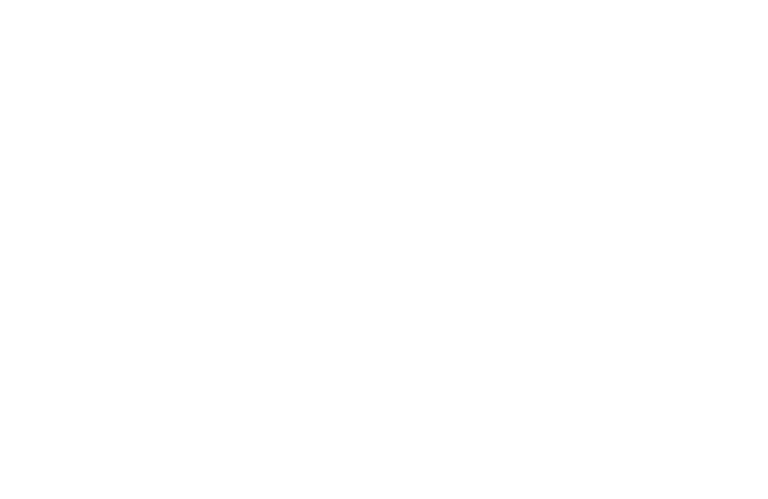

In [6]:
image_url = (
    landsat_img.select([3, 2, 1])
    .reproject(crs=image_crs, scale=cellsize * 4)
    .getThumbURL({'min': 0.0, 'max': 2500, 'region': study_region, 'dimensions': image_size})
)
Image(url=image_url, embed=True, format='png')

### ET Image Collection

In [7]:
def compute_et(image):
    """Return an ET image for each input Landsat 8 C2 SR image"""
    image_obj = model.Image.from_landsat_c2_sr(
        image, 
        et_reference_source=et_reference_source, 
        et_reference_band=et_reference_band
    )
    return image_obj.et
    
# Build the SIMS model for each image then compute and return ET
et_coll = ee.ImageCollection(landsat_coll.map(compute_et))

# pprint.pprint(ee.Image(et_coll.first()).getInfo())

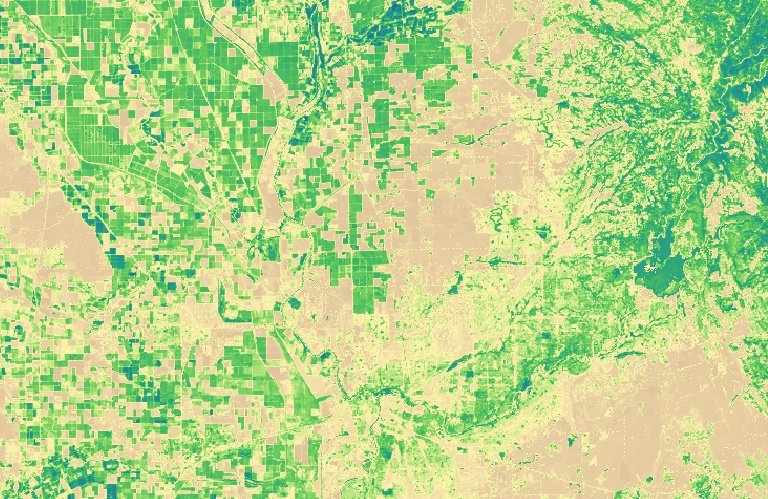

In [8]:
# Note, a thumbnail can't be generated for a full Landsat image at scale=30
image_url = (
    ee.Image(et_coll.mean())
    .reproject(crs=image_crs, scale=cellsize * 4)
    .getThumbURL({'min': 0, 'max': 12, 'palette': et_palette, 
                  'region': study_region, 'dimensions': image_size})
)
Image(url=image_url, embed=True, format='png')

### Custom Image Class Parameters 
It is also possible to pass custom parameter to the Image class as long as they are the same for all images.

For this example, the reference ET collection ID and band are being set to GRIDMET, and the temperature difference threshold is being changed from the default of 15 to 1 (to show that it works).

In [9]:
def custom_et(image):
    image_obj = model.Image.from_landsat_c2_sr(
        image, 
        et_reference_source='IDAHO_EPSCOR/GRIDMET', 
        et_reference_band='eto',
    )
    return image_obj.et
    
# Build the SIMS for each image then compute and return ET
et_coll = ee.ImageCollection(landsat_coll.map(custom_et))

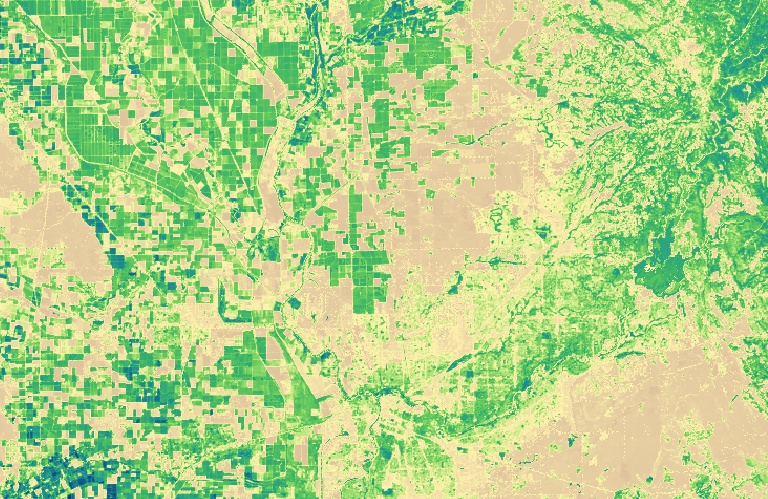

In [10]:
image_url = (
    ee.Image(et_coll.mean())
    .reproject(crs=image_crs, scale=cellsize * 4)
    .getThumbURL({'min': 0, 'max': 12, 'palette': et_palette, 
                  'region': study_region, 'dimensions': image_size})
)
Image(url=image_url, embed=True, format='png')

### Map the calculate method over the Landsat collection

In [11]:
def compute_vars(image):
    """Return an ET image for each input Landsat 8 C2 SR image"""
    image_obj = model.Image.from_landsat_c2_sr(
        image, 
        et_reference_source=et_reference_source, 
        et_reference_band=et_reference_band,
    )
    return image_obj.calculate(['et', 'et_reference', 'et_fraction'])
    
vars_coll = ee.ImageCollection(landsat_coll.map(compute_vars))

# pprint.pprint(ee.Image(et_coll.first()).getInfo())

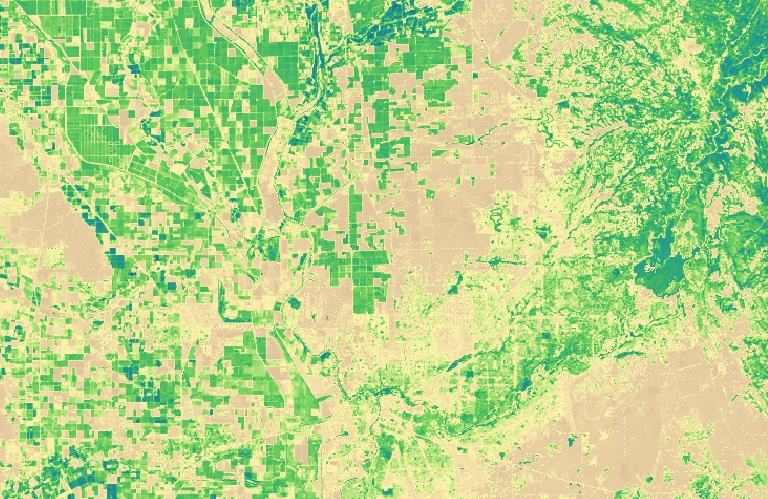

In [12]:
image_url = (
    ee.Image(vars_coll.select(['et']).mean())
    .reproject(crs=image_crs, scale=cellsize * 4)
    .getThumbURL({'min': 0, 'max': 12, 'palette': ','.join(et_palette), 
                  'region': study_region, 'dimensions': image_size})
)
Image(url=image_url, embed=True, format='png')